In [1]:
import matplotlib.pyplot as plt
import numpy as np
import Geodesics as gd
import Model as md
import cmath as cmt
import glob
import os
import time

In [2]:
def isBetween(z0,z1,z2):
    cross10 = z1.real*z0.imag-z0.real*z1.imag
    cross12 = z1.real*z2.imag-z2.real*z1.imag
    cross20 = z2.real*z0.imag-z0.real*z2.imag
    cross21 = -z1.real*z2.imag+z2.real*z1.imag
    isBe = (cross10*cross12) >= 0 and (cross20*cross21) >= 0
    return isBe

def entanglement_entropy(model):
    theta = np.linspace(0,2*np.pi,1000)
    delta = 0.01
    borderCenters = model.centers[model.border]
    borderNeigh = np.array(borderCenters[model.borderNeigh])
    wedges = np.zeros(len(borderCenters))
    for idx,z1 in enumerate(borderCenters):
        if idx%5==0:
            start = time.time()
            for idx2,z2 in enumerate(borderNeigh[idx,:]):
                for g in model.geodesicList:
                    x = isBetween(g.endpoints[0],z1,z2) 
                    y = isBetween(g.endpoints[1],z1,z2)
                    if bool((x and not y) or (not x and y)):
                        wedges[idx2] += 1
            end = time.time()
            print('Computing entropy. Time remaining: ' + str(round((end-start)*(len(borderCenters)-idx),2))+' s'+' '*100, end = '\r')
    wedges[int(len(borderCenters)/2):] = wedges[(int(len(borderCenters)/2)-1)::-1]
    wedges[int(len(borderCenters)/2)] = wedges[int(len(borderCenters)/2)-3]
    wedges[int(len(borderCenters)/2)-1] = wedges[int(len(borderCenters)/2)-3]
    return np.array(wedges)/len(model.border)

Finished defining model with 5 layers. It took: 1.39 s                                                                                                    
Entropy took: 188.38 s                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

KeyboardInterrupt: 

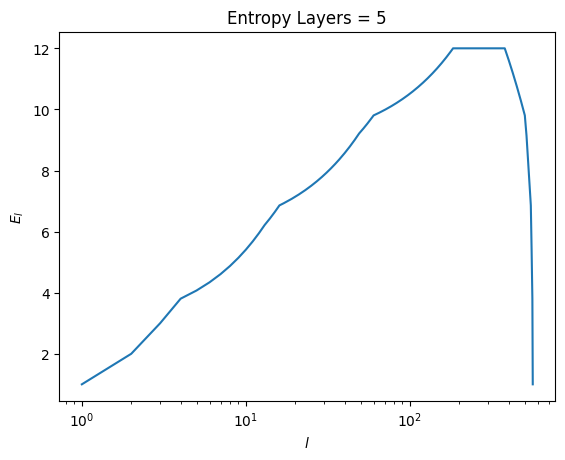

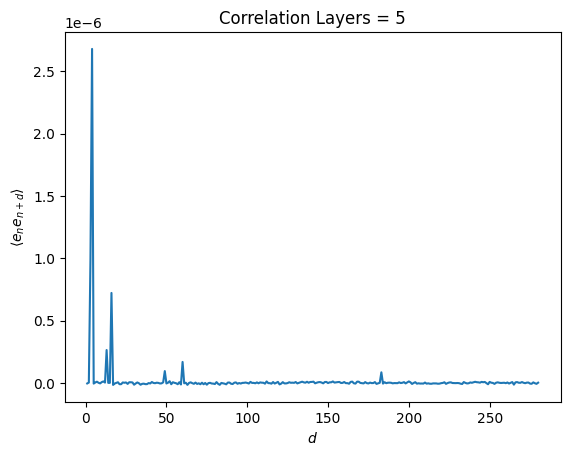

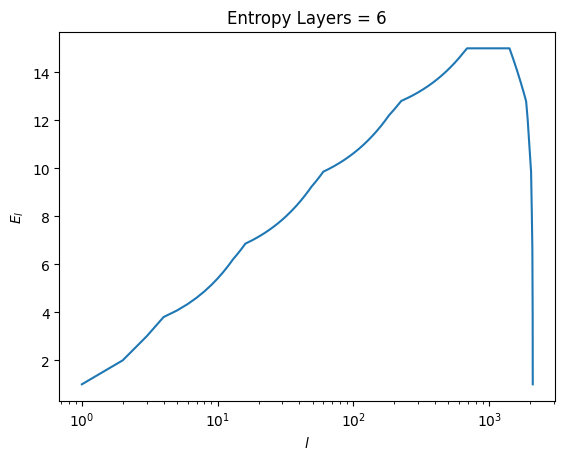

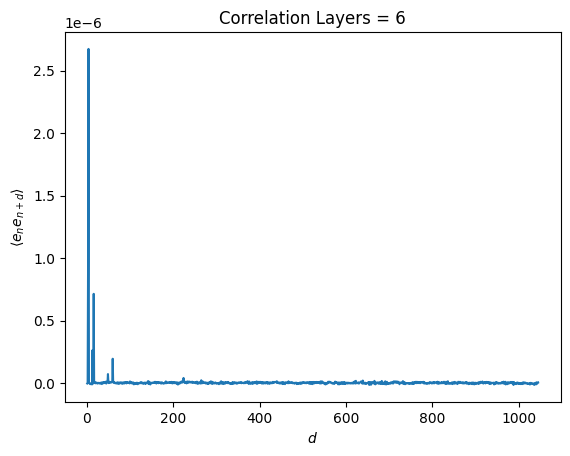

In [4]:

for nlayers in range(7,8):
    #Set up model
    p = 5; q = 4
    start = time.time()
    print("Defining model with " + str(nlayers) + " layers", end = '\r')
    model = md.FractonModel(p,q,nlayers, kernel = 'SRG')
    end = time.time()
    elapsed = end-start
    print("Finished defining model with " + str(nlayers) + " layers. It took: " + str(round(elapsed,2)) + ' s'+' '*100)
    
    #Lattice parameters
    nDecorr = 10 #Steps to decorrelate  
    nMeasurements = 100000 #Number of measurements
    saveFreq = 1000 #Save frequency
    
    # Define the directory where you want to save the files
    save_dir = "../Data/P"+str(p)+"Q"+str(q)+"/"+str(nlayers)+"Layers"

    # Check if the directory exists, if not, create it
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    #Number of spins in the border
    nBorder = len(model.border)
    distances = np.linspace(1,int(nBorder/2), int(nBorder/2))

    #Initialize correlation and states arrays
    corr = np.zeros(int(len(model.border)/2))
    corrTimeSeries = np.zeros((nMeasurements,int(len(model.border)/2)))
    
    
    #Initialize save counter
    saveCounter = 0
    elapsed = 0
    
    ##EntanglementEntropy
    start = time.time()
    ent_entr = entanglement_entropy(model)
    end = time.time()
    print('Entropy took: ' + str(round(end-start,2)) + ' s' + ' '*1000, end = '\n')
    borderCenters = model.centers[model.border]
    blockSizes = np.linspace(1,nBorder,nBorder)
    np.save(os.path.join(save_dir, "EntanglEntr.npy"),ent_entr)
    figEntr,axEntr = plt.subplots()
    axEntr.set_title("Entropy Layers = " + str(nlayers))
    axEntr.plot(blockSizes,ent_entr)
    axEntr.set_ylabel(r'$E_l$')
    axEntr.set_xlabel(r'$l$')
    axEntr.set_xscale('log')
    figEntr.savefig(os.path.join(save_dir, "EntanglEntr.eps"), format = 'eps', bbox_inches = 'tight', pad_inches = 0)

    #Simulation main loop

    for iteration in range(nMeasurements):
        start = time.time()
        model.decorrelate(nDecorr)
        temp = np.array(model.getBorderCorrelations()/nBorder)
        corrTimeSeries[iteration,:] = temp/nMeasurements
        corr += temp/nMeasurements
        saveCounter += 1
        end = time.time()
        elapsed += end - start
        if(saveCounter == saveFreq):
            print('Computing correlation. \tPercentage: ' + str(round(iteration/nMeasurements*100)) + '% \t' + str(round(iteration/elapsed)) + ' it/s' + '\t Time remaining: ' + str(round((elapsed*(nMeasurements-iteration)/iteration)/60,2)) +' min     ', end = '\r')
            np.save(os.path.join(save_dir, "Correlation" + ".npy"),np.array(corr))
            np.save(os.path.join(save_dir, "CorrelationTimeSeries" + ".npy"),np.array(corrTimeSeries))
            saveCounter = 0
    print('Correlation took: ' + str(round(elapsed,2))+' s'+' '*1000, end = '\n')

    figCorr, axCorr = plt.subplots()
    axCorr.set_title("Correlation Layers = " + str(nlayers))
    axCorr.plot(distances,corr/nMeasurements)
    axCorr.set_ylabel(r'$\left< e_ne_{n+d} \right>$')
    axCorr.set_xlabel(r'$d$')
    figCorr.savefig(os.path.join(save_dir, "CorrelationFigure.eps"), format = 'eps', bbox_inches = 'tight', pad_inches = 0)